# Hands on 06 - Pré processamento e aumentação de dados para Deep Learning

Redes neurais, na maioria das vezes, esperam algum tipo de dados estruturado e bem comportado como entrada. Na vida real (mesmo na astronomia/física) isso muitas vezes não é o caso, e recai sobre o pesquisador/aluno trabalhar os dados antes de utilizá-los para treinar uma rede. A parte de pré-processamento é uma das mais importantes durante um trabalho de Deep Learning e pode tomar muito tempo. Algumas vezes essa parte pode tomar mais tempo do que a definição da arquitetura da rede.

Além disso, muitas vezes o modo como fazemos esse tratamento inicial pode impactar bastante no resultado final. Não existe receita de bolo para esse tratamento, mas aqui iremos demonstrar algumas práticas importantes. Falaremos também sobre aumentação de dados e como isso pode melhorar o treinamento de uma rede.

In [153]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

## 1. Ler imagens em python

Imagens vindas da internet, como em desafios de dados, estão em formatos como `.jpeg` ou `.png`. O pacote [scikit-image](https://scikit-image.org), por exemplo, é especializado em trabalhar com imagens. 

Existem outros ([Pillow](https://pillow.readthedocs.io/en/stable/), [imageio](https://pypi.org/project/imageio/), [OpenCV](https://pypi.org/project/opencv-python/))

In [21]:
dog = skimage.io.imread('./images/saint_bernard_stanford.jpg')
print(type(dog), dog.shape)

<class 'numpy.ndarray'> (266, 400, 3)


In [228]:
print(f'Menor valor de pixel = {dog.min()}\nMaior valor do pixel = {dog.max()}')

Menor valor de pixel = 0
Maior valor do pixel = 255


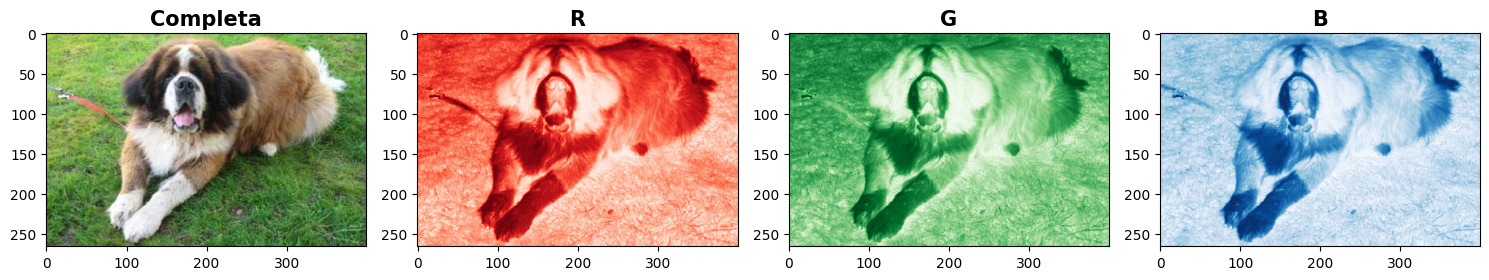

In [22]:
f, ax = plt.subplots(1, 4, figsize=[15,15])
titles = ['Completa', 'R', 'G', 'B']
cmaps = ['Reds', 'Greens', 'Blues']
for i in range(4):
    if i == 0:
        ax[i].imshow(dog)
    else:
        ax[i].imshow(dog[:,:,i-1], cmap=cmaps[i-1])
    ax[i].set_title(titles[i], fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

Em geral na Física imagens não vêm nos formatos comuns achados na internet. Observatórios astronômicos em geral usam arquivos `.fits`, enquanto dados advindo de simulações pode vir diretamente como numpy arrays.

A comunidade pithonica já tem pacotes destinados a realizar tarefas comuns em astronomia, o `astropy`, que pode ser usado para ler arquivos `.fits`.

In [176]:
pillars_img = np.zeros((1600, 1600, 3))
cwd = os.getcwd()
i = 0
for f in os.listdir(os.path.join(cwd, 'images')):
    if 'nmos' in f:
        hst = fits.open(os.path.join(cwd, 'images', f))
        header = hst[0].header
        img = hst[0].data
        print(type(img), img.shape)
        img = np.transpose(img)
        pillars_img[:,:,i] = img
        i+=1

<class 'numpy.ndarray'> (1600, 1600)
<class 'numpy.ndarray'> (1600, 1600)
<class 'numpy.ndarray'> (1600, 1600)


In [215]:
pillars_img_norm = np.zeros_like(pillars_img)
for i in range(3):
    band = pillars_img[:,:,i]
    band_filled = np.ma.log(band).filled(0)
    #print(band_filled.max())
    pillars_img_norm[:,:,i] = (band_filled - band_filled.min()) / np.ptp(band_filled)

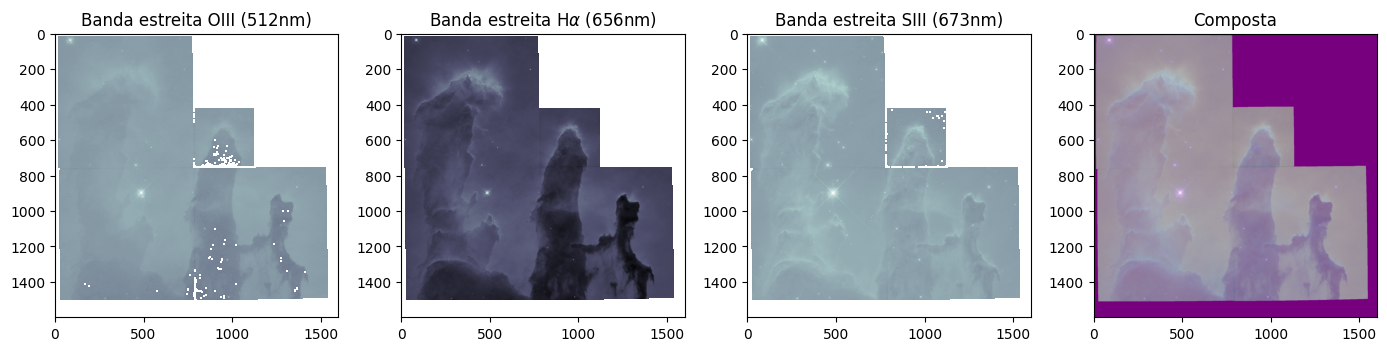

In [269]:
names = ['Banda estreita OIII (512nm)', r'Banda estreita H$\alpha$ (656nm)', 'Banda estreita SIII (673nm)', 'Composta']
f, ax = plt.subplots(1, 4, figsize=[14,6])
for i in range(4):
    if i == 3:
        ax[i].imshow(pillars_img_norm)
        ax[i].set_title(names[i])
    else:
        ax[i].imshow(np.ma.log10(pillars_img[:,:,i]), cmap='bone')
        ax[i].set_title(names[i])
plt.tight_layout()
plt.show()

In [227]:
print(f'Menor valor de pixel = {pillars_img.min()}\nMaior valor do pixel = {pillars_img.max()}')

Menor valor de pixel = -15.075413703918457
Maior valor do pixel = 3363.962890625


E finalmente, para arquivos salvos diretamente como numpy arrays, o carregamento é imediato

In [293]:
vis = np.load('/tf/dados4/challenge2GitPatrick/DataChallenge2/vis_cut_test_o2i.npy')
hjy = np.load('/tf/dados4/challenge2GitPatrick/DataChallenge2/hjy_cut_test_o2i.npy')
labels = np.load('/tf/dados4/challenge2GitPatrick/DataChallenge2/y_cut_test_o2i.npy')

## 2. Pré processamento

Os dados acima são uma parte das imagens disponibilizadas pelo II Strong Gravitational Lens Challenge, um desafio aberto a pesquisadores de todo mundo para classificação de imagens com/sem lenteamento gravitacional forte. As simulações visaram emular o que seria observado no observatório espacial **EUCLID**, que ainda está para ser lançado. Essa seleção tem 1000 imagens no filtro VIS e 1000 nos filtros H, J e Y. 

Vamos analisar algumas

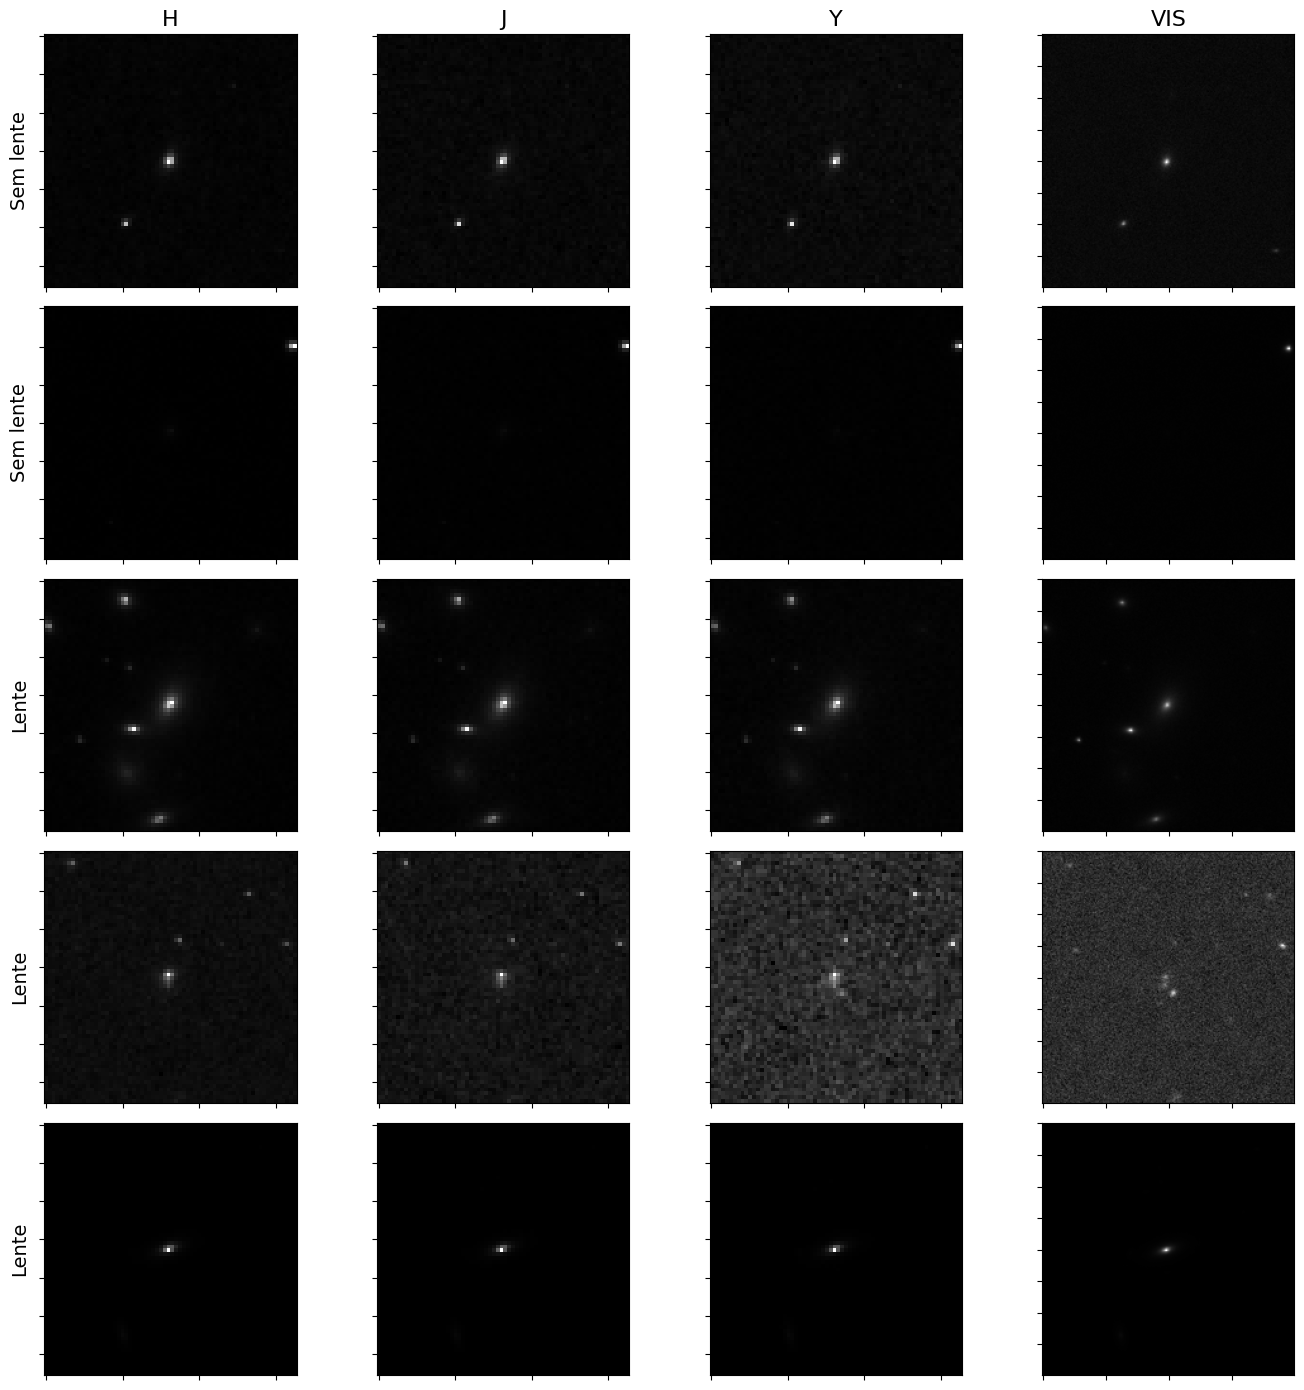

In [299]:
f, ax = plt.subplots(5, 4, figsize=[14,14])
indices = np.random.choice(range(vis.shape[0]), 5, replace=False)
titles = ['H', 'J', 'Y', "VIS"]
lab_names = ['Sem lente', 'Lente']
for i, ii in enumerate(indices):
    ax[i,0].set_ylabel(lab_names[labels[ii].argmax()], fontsize=14)
    for j in range(3):
        ax[i,j].imshow(hjy[ii,:,:,j], cmap='binary_r')
    #ax[i,3].imshow(hjy[ii,:,:,:])
    ax[i,3].imshow(vis[ii,:,:,0], cmap='binary_r')
    for j in range(4):
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].yaxis.set_ticklabels([])
        ax[0,j].set_title(titles[j], fontsize=16)

plt.tight_layout()
plt.show()

Os objetos que deveriam estar presente nas imagens mal são vistos! Em casos parecidos, o workflow segue mais ou menos assim:

1. Entender qual a razão do problema;
1. Processar a imagem:
    - Cortes de contraste
    - Resizing
    - Cropping
    - Dominuir o números de canais
1. Testar!

Primeiramente vamos entender porque as imagens não mostram quase nada.

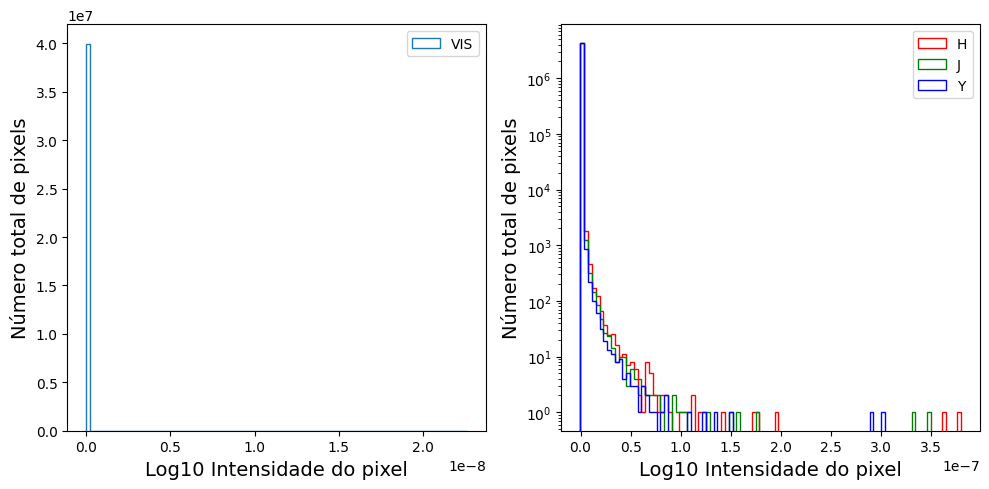

In [319]:

f, ax = plt.subplots(1, 2, figsize=[10,5])

ax[0].hist(vis.ravel(), 100, histtype='step', label='VIS')
ax[0].legend(loc='upper right')
c, bins, _ = ax[1].hist(hjy[:,:,:,0].ravel(), 100, histtype='step', color='r', label='H')
ax[1].hist(hjy[:,:,:,1].ravel(), bins, histtype='step', color='g', label='J')
ax[1].hist(hjy[:,:,:,2].ravel(), bins, histtype='step', color='b', label='Y', log=True)
ax[1].legend(loc='upper right')
for i in range(2):
    ax[i].set_xlabel('Log10 Intensidade do pixel', fontsize=14)
    ax[i].set_ylabel('Número total de pixels', fontsize=14)
plt.tight_layout()
plt.show()